In [38]:
import pandas as pd
from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality
from darts.dataprocessing.transformers import scaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from functools import reduce
from operator import add

In [123]:
# === Config ===
forecast_horizon = 90
ensemble_top_n = 2
fallback_lag = 30


In [124]:
# === Load Data ===
df = pd.read_csv("temp_1.csv", parse_dates=["Date"])
server_columns = df.columns.drop("Date")
series_list = [
    TimeSeries.from_dataframe(df, time_col="Date", value_cols=col)
    for col in server_columns
]

In [125]:
# === Seasonality Detection ===
def get_strongest_seasonality(ts, candidates=[5, 7, 14, 30, 60, 90, 365]):
    values = ts.univariate_values()
    max_lag = max(candidates)
    acf_vals = acf(values, nlags=max_lag, fft=True)
    results = []
    for m in candidates:
        if check_seasonality(ts, m=m, max_lag=max_lag, alpha=0.05):
            strength = abs(acf_vals[m])
            results.append((m, strength))
    if results:
        best_m = max(results, key=lambda x: x[1])[0]
        print(f"✔️ Strongest seasonality detected: {best_m}")
        return best_m
    print("⚠️ No seasonality detected. Using fallback.")
    return fallback_lag

lags = min(get_strongest_seasonality(s) for s in series_list)
print(f"Detected common seasonality lag: {lags}")

✔️ Strongest seasonality detected: 5
✔️ Strongest seasonality detected: 7
Detected common seasonality lag: 5


In [126]:
# === Train-Test Split ===
train_series = [s[:-forecast_horizon] for s in series_list]
val_series = [s[-forecast_horizon:] for s in series_list]


In [130]:
# === Scaling ===
scaler = Scaler(StandardScaler())
train_series_scaled = [scaler.fit_transform(s) for s in train_series]
val_series_scaled = [scaler.transform(s) for s in val_series]


In [137]:
# === Models ===
output_chunk_length = min(forecast_horizon, 30)
candidate_models = {
    "LightGBM": RegressionModel(LGBMRegressor(), lags=lags, output_chunk_length=output_chunk_length),
    "XGBoost": RegressionModel(XGBRegressor(), lags=lags, output_chunk_length=output_chunk_length),
    "Linear": RegressionModel(LinearRegression(), lags=lags, output_chunk_length=output_chunk_length),
}

In [147]:
# === Evaluate Models ===
rmse_scores = {}

for name, model in candidate_models.items():
    print(f"\n🔎 Evaluating model: {name}")
    model.fit(train_series_scaled)
    preds = model.historical_forecasts(
        series=train_series_scaled,
        forecast_horizon=forecast_horizon,
        stride=forecast_horizon,
        last_points_only=True,
        verbose=False
    )
    valid_rmse = []
    for true, pred in zip(val_series_scaled, preds):
        if len(true) == len(pred):
            valid_rmse.append(rmse(true, pred))
        else:
            print(f"⚠️ Length mismatch on series: pred={len(pred)}, true={len(true)}")
    if valid_rmse:
        avg_rmse = sum(valid_rmse) / len(valid_rmse)
        rmse_scores[name] = avg_rmse
        print(f"✅ [{name}] Avg RMSE: {avg_rmse:.2f} on {len(valid_rmse)} series")
    else:
        print(f"[{name}] No valid forecasts to calculate RMSE")


🔎 Evaluating model: LightGBM
⚠️ Length mismatch on series: pred=38, true=90
⚠️ Length mismatch on series: pred=38, true=90
[LightGBM] No valid forecasts to calculate RMSE

🔎 Evaluating model: XGBoost
⚠️ Length mismatch on series: pred=38, true=90
⚠️ Length mismatch on series: pred=38, true=90
[XGBoost] No valid forecasts to calculate RMSE

🔎 Evaluating model: Linear
⚠️ Length mismatch on series: pred=38, true=90
⚠️ Length mismatch on series: pred=38, true=90
[Linear] No valid forecasts to calculate RMSE


In [148]:
# === Select Top N Models ===
sorted_models = sorted(rmse_scores.items(), key=lambda x: x[1])
top_model_names = [name for name, _ in sorted_models[:ensemble_top_n]]
print(f"\n✅ Top {ensemble_top_n} models: {top_model_names}")



✅ Top 2 models: []


In [120]:
# === Final Fit + Forecast ===
top_forecasts = []

for name in top_model_names:
    model = candidate_models[name]
    model.fit(train_series_scaled)
    forecasts = model.predict(n=forecast_horizon, series=train_series_scaled)
    avg_forecast = reduce(add, forecasts) * (1.0 / len(forecasts))
    top_forecasts.append(avg_forecast)

In [97]:
# === Ensemble ===
ensemble_scaled = reduce(add, top_forecasts) * (1.0 / len(top_forecasts))
ensemble_final = scaler.inverse_transform(ensemble_scaled)
ensemble_final.plot(label=f"Ensemble Forecast (Top {ensemble_top_n} Models)")


✔️ Strongest seasonality detected: 5
✔️ Strongest seasonality detected: 7
Detected common seasonality lag: 5

🔎 Evaluating model: LightGBM
Validation sample: [[-0.29530156]
 [ 0.12509639]
 [ 0.92024909]
 [-0.24965835]
 [-0.31211747]]
Prediction sample: [[-0.60289853]
 [-0.56222942]
 [-0.55296859]
 [-0.55919264]
 [-0.55523599]]
numpy RMSE: 1.0086100662906727
Validation sample: [[-0.26166972]
 [-0.11993555]
 [ 0.46141475]
 [-0.52351759]
 [-0.46586301]]
Prediction sample: [[-0.65805174]
 [-0.62024868]
 [-0.60948113]
 [-0.61398203]
 [-0.61284005]]
numpy RMSE: 1.050568214011232
✅ [LightGBM] Avg RMSE: 1.03 on 2 series

🔎 Evaluating model: XGBoost
Validation sample: [[-0.29530156]
 [ 0.12509639]
 [ 0.92024909]
 [-0.24965835]
 [-0.31211747]]
Prediction sample: [[-0.60289853]
 [-0.56222942]
 [-0.55296859]
 [-0.55919264]
 [-0.55523599]]
numpy RMSE: 1.0086100662906727
Validation sample: [[-0.26166972]
 [-0.11993555]
 [ 0.46141475]
 [-0.52351759]
 [-0.46586301]]
Prediction sample: [[-0.65805174]
 

<Axes: xlabel='Date'>

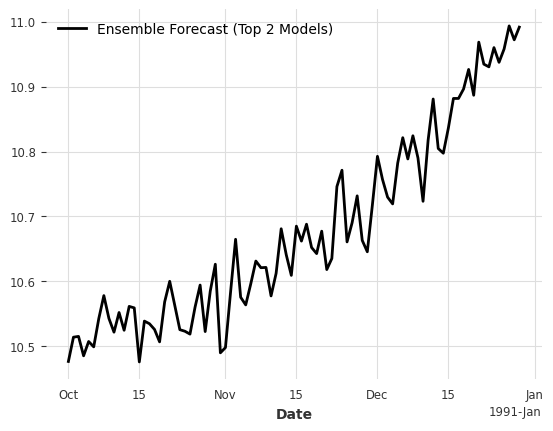

In [158]:
from functools import reduce
from operator import add
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse
from darts.models import RegressionModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.stattools import acf
from darts.utils.statistics import check_seasonality

# === Config ===
forecast_horizon = 90
ensemble_top_n = 2
fallback_seasonality = 60

# === Load Data ===
df = pd.read_csv("temp_1.csv", parse_dates=["Date"])
server_columns = df.columns.drop("Date")

# Create TimeSeries for each server
series_list = [
    TimeSeries.from_dataframe(df, time_col="Date", value_cols=col)
    for col in server_columns
    if df[col].notna().sum() > forecast_horizon
]



# === Seasonality Detection ===
def get_strongest_seasonality(ts, candidates=[5, 7, 14, 30, 60, 90, 365]):
    values = ts.univariate_values()
    max_lag = max(candidates)
    acf_vals = acf(values, nlags=max_lag, fft=True)
    results = []
    for m in candidates:
        if check_seasonality(ts, m=m, max_lag=max_lag, alpha=0.05):
            strength = abs(acf_vals[m])
            results.append((m, strength))
    if results:
        best_m = max(results, key=lambda x: x[1])[0]
        print(f"✔️ Strongest seasonality detected: {best_m}")
        return best_m
    print("⚠️ No seasonality detected. Using fallback.")
    return fallback_seasonality

# Use min detected seasonality
lags = min(get_strongest_seasonality(s) for s in series_list)
print(f"Detected common seasonality lag: {lags}")

# === Split ===
train_series = [s[:-forecast_horizon] for s in series_list if len(s) > forecast_horizon + lags]
val_series = [s[-forecast_horizon:] for s in series_list if len(s) > forecast_horizon + lags]

# === Scale ===
scaler = Scaler(StandardScaler())
train_series_scaled = [scaler.fit_transform(s) for s in train_series]
val_series_scaled = [scaler.transform(s) for s in val_series]

# === Candidate Models ===
candidate_models = {
    "LightGBM": RegressionModel(LGBMRegressor(), lags=lags, output_chunk_length=forecast_horizon),
    "XGBoost": RegressionModel(XGBRegressor(), lags=lags, output_chunk_length=forecast_horizon),
    "Linear": RegressionModel(LinearRegression(), lags=lags, output_chunk_length=forecast_horizon),
}

# === Evaluate Models ===

rmse_scores = {}

import numpy as np

def numpy_rmse(true_ts, pred_ts):
    true_vals = true_ts.values()
    pred_vals = pred_ts.values()
    return np.sqrt(np.mean((true_vals - pred_vals) ** 2))

for name, model in candidate_models.items():
    print(f"\n🔎 Evaluating model: {name}")
    model.fit(train_series_scaled)

    valid_rmse = []

    for train_s, val_s in zip(train_series_scaled, val_series_scaled):
        try:
            # === Safely extract lags from model ===
            if isinstance(model.lags, dict):
                if "lags" in model.lags:
                    lags_val = model.lags["lags"]
                elif "target" in model.lags:
                    lags_val = model.lags["target"]
                else:
                    raise ValueError(f"Unsupported dict lags format: {model.lags}")
            else:
                lags_val = model.lags

            # === Determine max lag needed ===
            if isinstance(lags_val, int):
                lags_to_use = lags_val
            elif isinstance(lags_val, (list, tuple)):
                lags_to_use = abs(min(lags_val))  # use max lookback
            else:
                raise ValueError(f"Unsupported lags format: {lags_val} ({type(lags_val)})")

            # === Compute start index for historical_forecasts ===
            start_index = len(train_s) - forecast_horizon - lags_to_use
            if start_index <= 0:
                print(f"⚠️ Series too short for backtesting with {name}")
                continue

            pred_series = model.historical_forecasts(
                series=train_s,
                forecast_horizon=forecast_horizon,
                stride=1,
                start=int(start_index),
                last_points_only=False,
                verbose=False
            )

            if not pred_series:
                print("⚠️ No forecasts returned")
                continue

            last_forecast = pred_series[-1]

            if len(last_forecast) != len(val_s):
                print(f"⚠️ Length mismatch: pred={len(last_forecast)}, true={len(val_s)}")
                continue

            print(f"Validation sample: {val_s.values()[:5]}")
            print(f"Prediction sample: {last_forecast.values()[:5]}")

            # Use numpy_rmse to avoid issues with Darts rmse
            error = numpy_rmse(val_s, last_forecast)
            print(f"numpy RMSE: {error}")

            valid_rmse.append(error)

        except Exception as e:
            print(f"❌ Exception for model {name}: {e}")

    if valid_rmse:
        avg_rmse = sum(valid_rmse) / len(valid_rmse)
        rmse_scores[name] = avg_rmse
        print(f"✅ [{name}] Avg RMSE: {avg_rmse:.2f} on {len(valid_rmse)} series")
    else:
        print(f"[{name}] No valid forecasts to calculate RMSE")

# === Top Models ===
sorted_models = sorted(rmse_scores.items(), key=lambda x: x[1])
top_model_names = [name for name, _ in sorted_models[:ensemble_top_n]]
print(f"\n✅ Top {ensemble_top_n} models: {top_model_names}")

# === Final Forecast ===
top_forecasts = []

for name in top_model_names:
    model = candidate_models[name]
    model.fit(train_series_scaled)
    forecasts = model.predict(n=forecast_horizon, series=train_series_scaled)
    avg_forecast = reduce(add, forecasts) * (1.0 / len(forecasts))
    top_forecasts.append(avg_forecast)

ensemble_scaled = reduce(add, top_forecasts) * (1.0 / len(top_forecasts))
ensemble_final = scaler.inverse_transform(ensemble_scaled)

# === Plot ===
ensemble_final.plot(label=f"Ensemble Forecast (Top {ensemble_top_n} Models)")
